# MODELISATION ET EVALUATION

**Q1. Pourquoi organiser ses imports en début de notebook ?**

R1. Cela garantit que tout le code bénéficie des mêmes dépendances et facilite la lecture, la vérification et la maintenance du notebook. On évite aussi les erreurs inattendues dues à un mauvais ordre d’imports.

**Q2. Pourquoi avoir configuré les warnings (UndefinedMetricWarning) et le seed (RANDOM_STATE) ?**

R2. Filtrer les warnings permet d’obtenir un notebook propre, surtout avec des modèles baselines comme DummyClassifier. Mettre un seed assure la reproductibilité de tous mes résultats de cross-validation et d’entraînement, ce qui est essentiel en science des données.

**Q3. À quoi servent les scorers personnalisés dans la cross-validation ?**

R3. Définir des scorers avec zero_division=0 évite les divisions par zéro et clarifie l’attribution du score dans le cas où aucune classe positive n’est prédite, ce qui est fréquent sur des jeux de données déséquilibrés ou pour des modèles baselines.

In [98]:
# ============================================================
# IMPORTS ET CONFIGURATION
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.exceptions import UndefinedMetricWarning

### Pipelines et préprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Modèles et évaluation
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold



### Modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

### Evaluation

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, 
    roc_auc_score, classification_report,
    make_scorer, precision_score, recall_score, f1_score
)


# Configuration
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
plt.style.use('seaborn-v0_8')

RANDOM_STATE = 42

# Scorers personnalisés pour éviter les warnings
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

In [99]:
# ============================================================
# CHARGEMENT ET PRÉPARATION DES DONNÉES
# ============================================================

# Charger le dataset exporter depuis le notebook d'exploration

df  = pd.read_csv('exports/dataset_export.csv')

## Préparation des données pour le modèle
## Conversion de la colonne 'augementation_salaire_precedente' en numérique

df['augementation_salaire_precedente'] = pd.to_numeric(
    df['augementation_salaire_precedente'].str.replace('%', '').str.strip(), 
    errors='coerce'
)



In [100]:
df

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,sous_utilisation_competences,satisfaction_moyenne,nb_domaines_insatisfaits,score_surcharge,chute_performance,demotivation_performeur,manque_developpement,performeur_stagnant,parent_burnout,nb_signaux_alerte
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,2.666667,2.00,3,2,0,1.00,6.000000,0,0,3
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3.333333,3.00,1,0,-2,1.00,2.500000,0,0,0
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,3.500000,3.00,1,2,-1,0.00,0.000000,0,0,1
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,4.000000,3.25,0,2,0,-0.25,2.000000,0,0,1
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,3.000000,2.50,2,0,0,0.50,0.500000,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,2061,36,M,2571,Marié(e),Consulting,Consultant,4,80,17,...,5.666667,3.25,0,0,1,-0.25,1.250000,0,0,0
1466,2062,39,M,9991,Marié(e),Consulting,Manager,4,80,9,...,2.250000,2.25,2,0,-1,0.75,1.166667,0,0,1
1467,2064,27,M,6142,Marié(e),Consulting,Tech Lead,1,80,6,...,2.000000,2.25,3,2,0,1.75,6.000000,0,0,3
1468,2065,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,80,17,...,5.666667,3.00,2,0,-1,0.00,2.250000,0,0,0


**Q1. Pourquoi séparer le jeu d’entraînement et le jeu de test ?**  
R1. On sépare les données pour évaluer la capacité des modèles à généraliser sur des exemples jamais vus. Cela évite la sur-optimisation sur le training set et permet de détecter l’overfitting.

**Q2. À quoi sert le préprocessing (normalisation, encodage…) avant d’entraîner les modèles ?**  
R2. Le préprocessing harmonise les données (variables catégorielles, échelles différentes) pour que chaque modèle soit entraîné dans des conditions optimales, sans biais dû au format ou à la distribution initiale.

**Q3. Pourquoi documenter les étapes de préparation (imputation, sélection des features…) ?**  
R3. Ces étapes affectent directement la performance du modèle. Les décrire montre que le dataset a été nettoyé et préparé consciencieusement, ce qui renforce la crédibilité et la reproductibilité de mon travail.

In [101]:
# Définition complète des colonnes par catégorie

identifier_vars = ['id_employee']

target_var = 'attrition'

binary_vars = [
    'genre', 'statut_marital', 
    'heure_supplementaires', 'ayant_enfants'
]

categorical_vars = [
    'poste', 'domaine_etude', 'distance_categorie',
    'frequence_deplacement', 'departement'
]

numeric_vars = [
    'age', 'revenu_mensuel', 'nombre_experiences_precedentes',
    'nombre_heures_travailless', 'annee_experience_totale',
    'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel',
    'satisfaction_employee_environnement', 'note_evaluation_precedente',
    'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail',
    'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso',
    'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies',
    'nombre_employee_sous_responsabilite', 'distance_domicile_travail',
    'niveau_education', 'annees_depuis_la_derniere_promotion',
    'annes_sous_responsable_actuel', 'surqualification',
    'profil_risque_heures_sup_dept', 'stagnation_carriere',
    'sous_utilisation_competences', 'satisfaction_moyenne',
    'nb_domaines_insatisfaits', 'score_surcharge', 'chute_performance',
    'demotivation_performeur', 'manque_developpement',
    'performeur_stagnant', 'parent_burnout', 'nb_signaux_alerte',
    'augementation_salaire_precedente'
]

columns_to_use = binary_vars + categorical_vars + numeric_vars

In [102]:
# Séparer features et target
X = df[columns_to_use]
y = df['attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Preprocessing pipeline
preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), binary_vars + categorical_vars),
    (StandardScaler(), numeric_vars))

# Calcul du poids pour équilibrer les classes
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight:.2f}")

Scale pos weight: 4.83



**Q1. Pourquoi avoir créé une fonction d’évaluation centralisée pour les modèles ?**  
R1. Cela évite la duplication de code, réduit les risques d’erreur et garantit que tous les modèles sont évalués avec la même méthodologie (cross-validation, test final, métriques affichées).

**Q2. À quoi sert la fonction d’interprétation de la matrice de confusion ?**  
R2. Elle permet une lecture qualitative (en plus des métriques quantitatives) pour comprendre les types d’erreurs du modèle : combien de vrais positifs, faux négatifs, etc. C’est important pour l’explicabilité, notamment dans des contextes métier sensibles.

**Q3. Pourquoi automatiser le reporting des scores et visualisations ?**  
R3. Cela accélère la comparaison entre modèles. La visualisation synthétise l’information et permet de repérer rapidement quel modèle surpasse les autres, et sur quels aspects.


In [103]:
# ============================================================
# FONCTIONS UTILITAIRES
# ============================================================
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, cv=5):
    """
    Évalue un modèle avec cross-validation et test final.
    
    Returns:
        dict: Dictionnaire contenant toutes les métriques
    """
    # Cross-validation
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True
    )
    
    # Entraînement final
    model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Métriques de test
    test_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Affichage
    print(f"\n{'='*60}")
    print(f"MODÈLE : {model_name}")
    print(f"{'='*60}")
    print(f"\n--- Cross-Validation (CV={cv}) ---")
    print(f"AUC : {cv_results['test_roc_auc'].mean():.3f} (+/- {cv_results['test_roc_auc'].std():.3f})")
    print(f"Accuracy : {cv_results['test_accuracy'].mean():.3f} (+/- {cv_results['test_accuracy'].std():.3f})")
    print(f"Precision : {cv_results['test_precision'].mean():.3f} (+/- {cv_results['test_precision'].std():.3f})")
    print(f"Recall : {cv_results['test_recall'].mean():.3f} (+/- {cv_results['test_recall'].std():.3f})")
    print(f"F1-score : {cv_results['test_f1'].mean():.3f} (+/- {cv_results['test_f1'].std():.3f})")
    
    print(f"\n--- Test Set ---")
    print(f"AUC : {test_auc:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Pas de démission', 'Démission']))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                   display_labels=['Pas de démission', 'Démission'])
    disp.plot(cmap='Greens')
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.show()
    
    interpreter_matrice_confusion(y_test, y_pred)
    
    # Retourner les résultats pour comparaison
    return {
        'model_name': model_name,
        'cv_auc_mean': cv_results['test_roc_auc'].mean(),
        'cv_auc_std': cv_results['test_roc_auc'].std(),
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_precision_mean': cv_results['test_precision'].mean(),
        'cv_recall_mean': cv_results['test_recall'].mean(),
        'cv_f1_mean': cv_results['test_f1'].mean(),
        'test_auc': test_auc,
        'model': model
    }


# Fonction pour lire la matrice de confusion
def interpreter_matrice_confusion(y_true, y_pred):
    """
    Interprète la matrice de confusion pour un problème de démission
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print("\n=== Interprétation de la Matrice de Confusion ===")
    print(f"Vrais Négatifs (TN): {tn} - Employés qui ne démissionnent pas et correctement prédits")
    print(f"Faux Positifs (FP): {fp} - Employés qui NE démissionnent PAS mais prédits comme démissionnaires")
    print(f"Faux Négatifs (FN): {fn} - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)")
    print(f"Vrais Positifs (TP): {tp} - Employés qui démissionnent et correctement prédits")
    
    print(f"\nTotal de prédictions: {tn + fp + fn + tp}")
    print(f"Démissions réelles dans le test: {tp + fn}")
    print(f"Démissions prédites: {tp + fp}")
    
    # Métriques dérivées
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
        print(f"\nPrécision: {precision:.3f} - Parmi ceux prédits comme démissionnaires, {precision*100:.1f}% le sont vraiment")
    
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
        print(f"Recall (Sensibilité): {recall:.3f} - Le modèle détecte {recall*100:.1f}% des démissions réelles")
    
    if (tn + fp) > 0:
        specificity = tn / (tn + fp)
        print(f"Spécificité: {specificity:.3f} - Le modèle identifie {specificity*100:.1f}% des non-démissions")



**Q1. Pourquoi intégrer à la fois des baselines (DummyClassifier) et des modèles plus complexes (LogisticRegression, KNN, LightGBM) ?**  
R1. Les baselines posent une référence minimale : tout vrai modèle doit faire mieux. Les modèles complexes sont testés pour vérifier qu’ils apportent un gain réel sur le problème et permettent d’étudier l’effet de la complexité.

**Q2. Pourquoi utiliser des pipelines pour certains modèles ?**  
R2. Les pipelines automatisent le préprocessing et l’entraînement en une seule étape, ce qui garantit un workflow cohérent et évite d’appliquer le préprocessing séparément pour chaque modèle.

**Q3. Comment choisir les modèles à comparer ?**  
R3. On sélectionne les modèles selon leur adéquation au problème (linéaire, non-linéaire, capacité à gérer le déséquilibre, etc.), leur popularité en data science et leur performance attendue sur le dataset.

In [104]:
# ============================================================
# DÉFINITION DES MODÈLES À COMPARER
# ============================================================
models = {
    'DummyClassifier (stratified)': DummyClassifier(strategy='stratified', random_state=RANDOM_STATE),
    'Logistic Regression': make_pipeline(preprocessor, LogisticRegression(class_weight='balanced',max_iter=1000,random_state=RANDOM_STATE)),
    'KNN': make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=5)),
    'LightGBM': make_pipeline(preprocessor, LGBMClassifier(objective='binary',scale_pos_weight=scale_pos_weight,  # ← Gestion déséquilibre
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=RANDOM_STATE)),
    'SVM' : make_pipeline(preprocessor, SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
   
}


**Q1. Pourquoi utiliser la cross-validation pour chaque modèle ?**  
R1. La cross-validation donne une estimation robuste de la performance sur différents sous-ensembles de données. Cela réduit le risque qu’un résultat soit dû à une composition particulière du jeu d’entraînement.

**Q2. Que signifie comparer les scores CV et test ?**  
R2. Un modèle fiable doit avoir des scores similaires en cross-validation et sur le test set. Si la performance chute sur le test, c’est le signe d’un sur-apprentissage.

**Q3. Que permettent d’illustrer les matrices de confusion séparément ?**  
R3. Elles montrent la capacité du modèle à prédire chaque classe. Elles révèlent les éventuels biais (par exemple : sous-détection des démissions) qui pourraient ne pas apparaître dans les scores globaux.


MODÈLE : DummyClassifier (stratified)

--- Cross-Validation (CV=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)) ---
AUC : 0.505 (+/- 0.021)
Accuracy : 0.725 (+/- 0.011)
Precision : 0.180 (+/- 0.037)
Recall : 0.169 (+/- 0.035)
F1-score : 0.174 (+/- 0.036)

--- Test Set ---
AUC : 0.475
                  precision    recall  f1-score   support

Pas de démission       0.86      0.82      0.84       320
       Démission       0.10      0.12      0.11        48

        accuracy                           0.73       368
       macro avg       0.48      0.47      0.48       368
    weighted avg       0.76      0.73      0.75       368



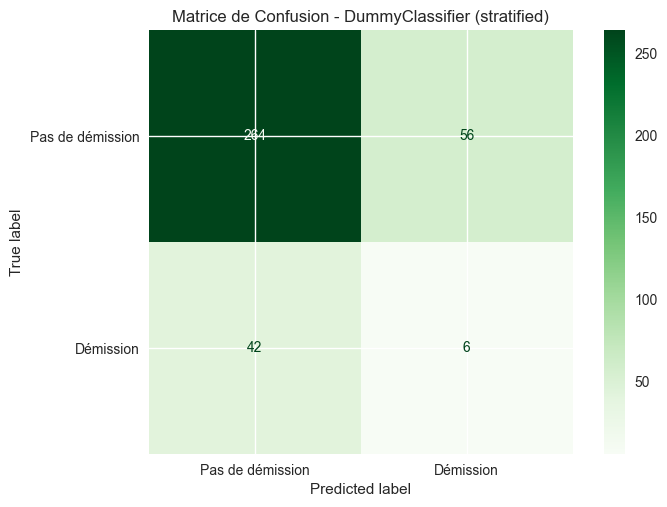


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 264 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 56 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 42 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 6 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 62

Précision: 0.097 - Parmi ceux prédits comme démissionnaires, 9.7% le sont vraiment
Recall (Sensibilité): 0.125 - Le modèle détecte 12.5% des démissions réelles
Spécificité: 0.825 - Le modèle identifie 82.5% des non-démissions

MODÈLE : Logistic Regression

--- Cross-Validation (CV=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)) ---
AUC : 0.832 (+/- 0.030)
Accuracy : 0.771 (+/- 0.050)
Precision : 0.416 (+/- 0.064)
Recall : 0.746 (+/- 0.064)
F1-score : 0.532 (+/- 0.066)

--- Test Set ---
AUC : 0.788

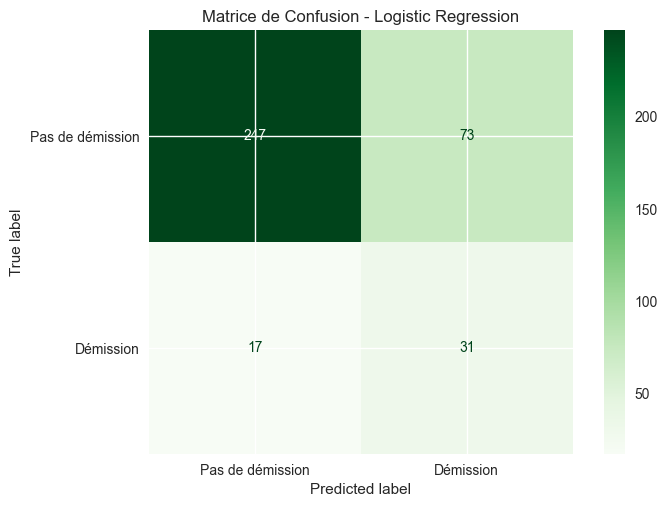


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 247 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 73 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 17 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 31 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 104

Précision: 0.298 - Parmi ceux prédits comme démissionnaires, 29.8% le sont vraiment
Recall (Sensibilité): 0.646 - Le modèle détecte 64.6% des démissions réelles
Spécificité: 0.772 - Le modèle identifie 77.2% des non-démissions

MODÈLE : KNN

--- Cross-Validation (CV=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)) ---
AUC : 0.722 (+/- 0.030)
Accuracy : 0.836 (+/- 0.016)
Precision : 0.593 (+/- 0.144)
Recall : 0.175 (+/- 0.026)
F1-score : 0.268 (+/- 0.044)

--- Test Set ---
AUC : 0.655
            

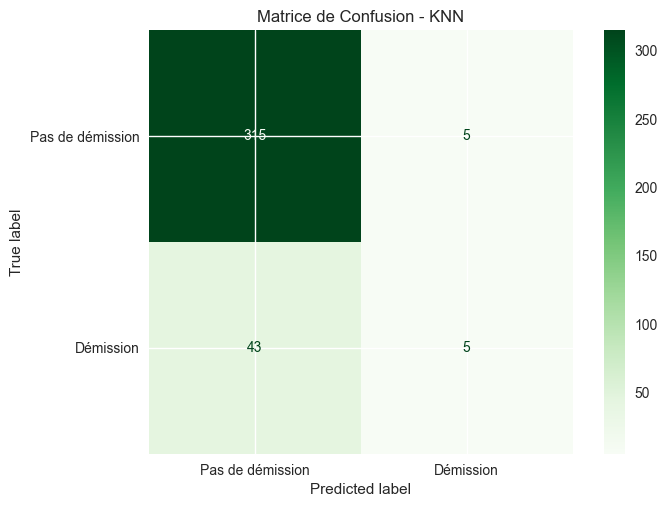


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 315 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 5 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 43 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 5 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 10

Précision: 0.500 - Parmi ceux prédits comme démissionnaires, 50.0% le sont vraiment
Recall (Sensibilité): 0.104 - Le modèle détecte 10.4% des démissions réelles
Spécificité: 0.984 - Le modèle identifie 98.4% des non-démissions


/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Reposit


MODÈLE : LightGBM

--- Cross-Validation (CV=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)) ---
AUC : 0.818 (+/- 0.038)
Accuracy : 0.849 (+/- 0.012)
Precision : 0.555 (+/- 0.035)
Recall : 0.629 (+/- 0.068)
F1-score : 0.588 (+/- 0.037)

--- Test Set ---
AUC : 0.754
                  precision    recall  f1-score   support

Pas de démission       0.91      0.91      0.91       320
       Démission       0.38      0.38      0.38        48

        accuracy                           0.84       368
       macro avg       0.64      0.64      0.64       368
    weighted avg       0.84      0.84      0.84       368



/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ppluton/Documents/Repositories/OC4_classification/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


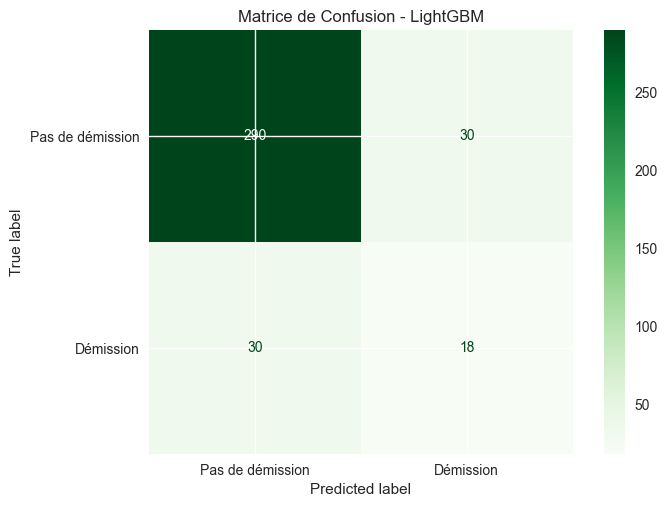


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 290 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 30 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 30 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 18 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 48

Précision: 0.375 - Parmi ceux prédits comme démissionnaires, 37.5% le sont vraiment
Recall (Sensibilité): 0.375 - Le modèle détecte 37.5% des démissions réelles
Spécificité: 0.906 - Le modèle identifie 90.6% des non-démissions

MODÈLE : SVM

--- Cross-Validation (CV=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)) ---
AUC : 0.828 (+/- 0.033)
Accuracy : 0.831 (+/- 0.019)
Precision : 0.508 (+/- 0.045)
Recall : 0.640 (+/- 0.068)
F1-score : 0.565 (+/- 0.045)

--- Test Set ---
AUC : 0.789
             

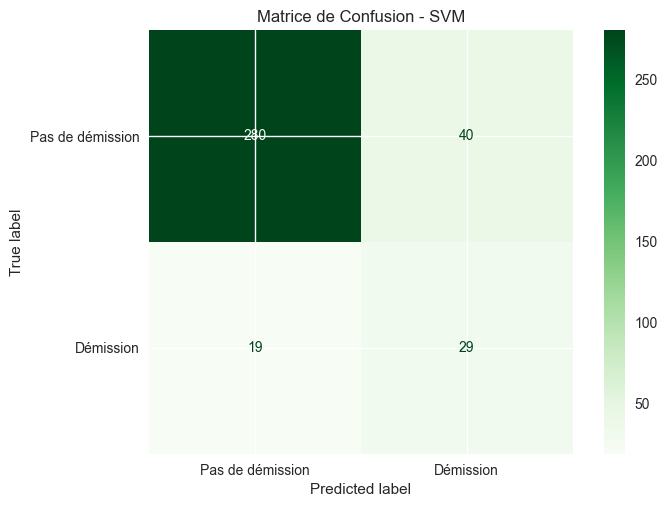


=== Interprétation de la Matrice de Confusion ===
Vrais Négatifs (TN): 280 - Employés qui ne démissionnent pas et correctement prédits
Faux Positifs (FP): 40 - Employés qui NE démissionnent PAS mais prédits comme démissionnaires
Faux Négatifs (FN): 19 - Employés qui démissionnent mais prédits comme restants (⚠️ RISQUE)
Vrais Positifs (TP): 29 - Employés qui démissionnent et correctement prédits

Total de prédictions: 368
Démissions réelles dans le test: 48
Démissions prédites: 69

Précision: 0.420 - Parmi ceux prédits comme démissionnaires, 42.0% le sont vraiment
Recall (Sensibilité): 0.604 - Le modèle détecte 60.4% des démissions réelles
Spécificité: 0.875 - Le modèle identifie 87.5% des non-démissions


In [105]:
# ============================================================
# ENTRAÎNEMENT ET ÉVALUATION DES MODÈLES
# ============================================================
results = []

for model_name, model in models.items():
    result = evaluate_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        model_name=model_name,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    )
    results.append(result)


**Q1. Comment interpréter le tableau de comparaison des modèles ?**  
R1. Il permet de juger quel modèle surpasse les autres selon l’AUC, l’accuracy, le recall, etc. Un bon modèle doit avoir un bon compromis toutes métriques confondues, pas seulement un score maximal sur une métrique unique.

**Q2. Que permet la visualisation comparative (barplots des scores) ?**  
R2. Elle synthétise en un coup d’œil les écarts de performance entre modèles, et met en évidence la stabilité ou la dispersion des scores selon les folds de cross-validation.

**Q3. Pourquoi souligner explicitement le meilleur modèle choisi ?**  
R3. Cela démontre une démarche scientifique et rationnelle dans la prise de décision finale. Expliquer ce choix permet aussi de défendre l’intérêt de ce modèle pour une utilisation opérationnelle ou future.



TABLEAU COMPARATIF DES MODÈLES
                  model_name  cv_auc_mean  cv_auc_std  cv_accuracy_mean  cv_precision_mean  cv_recall_mean  cv_f1_mean  test_auc
                         SVM     0.828080    0.032657          0.831189           0.508209        0.639829    0.564927  0.789225
         Logistic Regression     0.831947    0.030499          0.771259           0.415664        0.745946    0.532229  0.788411
                    LightGBM     0.818437    0.038279          0.849371           0.554926        0.629445    0.587924  0.754297
                         KNN     0.721820    0.029697          0.835734           0.592572        0.174538    0.268262  0.654687
DummyClassifier (stratified)     0.504611    0.020933          0.725031           0.179683        0.169132    0.174232  0.475000


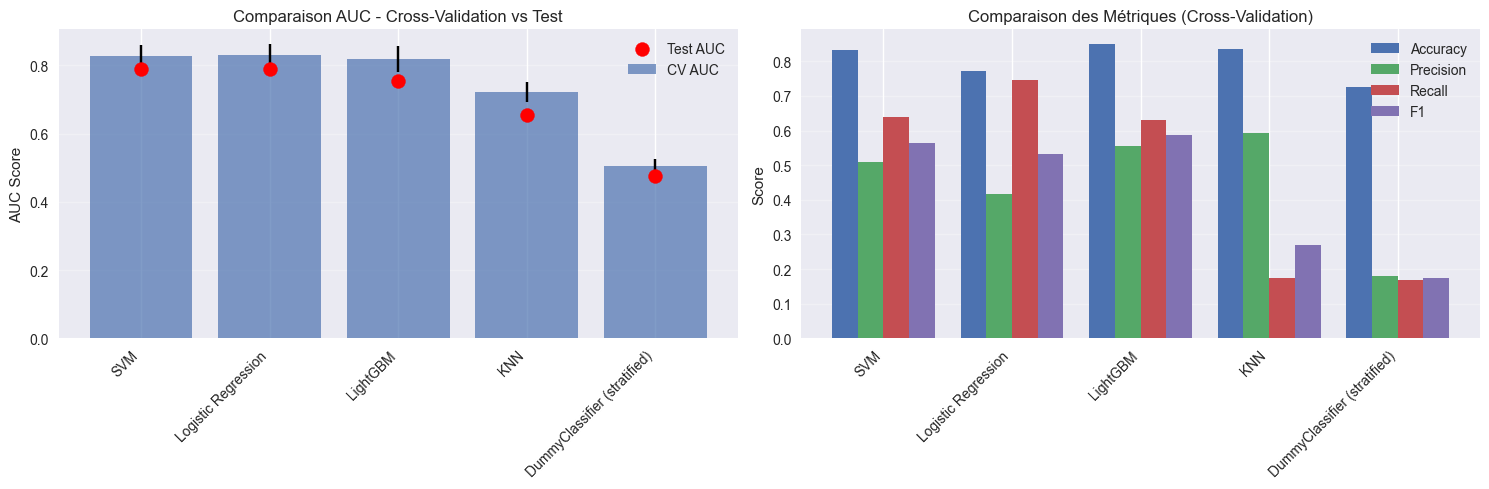


MEILLEUR MODÈLE : SVM
AUC Test : 0.789


In [106]:
# ============================================================
# COMPARAISON FINALE DES MODÈLES
# ============================================================
# Créer un DataFrame de comparaison
results_df = pd.DataFrame(results)
results_df = results_df.drop('model', axis=1)  # Enlever l'objet model pour l'affichage
results_df = results_df.sort_values('test_auc', ascending=False)

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES MODÈLES")
print("="*80)
print(results_df.to_string(index=False))

# Visualisation comparative
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1 : AUC
ax1 = axes[0]
x_pos = np.arange(len(results_df))
ax1.bar(x_pos, results_df['cv_auc_mean'], yerr=results_df['cv_auc_std'], 
        alpha=0.7, capsize=10, label='CV AUC')
ax1.scatter(x_pos, results_df['test_auc'], color='red', s=100, 
            label='Test AUC', zorder=3)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax1.set_ylabel('AUC Score')
ax1.set_title('Comparaison AUC - Cross-Validation vs Test')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Graphique 2 : Métriques multiples
ax2 = axes[1]
metrics_to_plot = ['cv_accuracy_mean', 'cv_precision_mean', 'cv_recall_mean', 'cv_f1_mean']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = width * (i - 1.5)
    ax2.bar(x + offset, results_df[metric], width, 
            label=metric.replace('cv_', '').replace('_mean', '').capitalize())

ax2.set_xticks(x)
ax2.set_xticklabels(results_df['model_name'], rotation=45, ha='right')
ax2.set_ylabel('Score')
ax2.set_title('Comparaison des Métriques (Cross-Validation)')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print(f"MEILLEUR MODÈLE : {results_df.iloc[0]['model_name']}")
print(f"AUC Test : {results_df.iloc[0]['test_auc']:.3f}")
print("="*80)
